In [1]:
import sys
sys.path.insert(0, "../../")

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import flax.linen as nn
from matplotlib import pyplot as plt
import module.util as util
import optax
from tqdm import tqdm

## Different Diffusion Processes

We want to reduce the initial dispersion of the data as the standard deviation in the usual Ohrnstein Uhlenbeck process initially scales as $\sim \sqrt{t}$. When requiring that the solution to the process is given by:
$$
x_t = e^{-\alpha t} x_0  + (1 - e^{-\beta t}) \xi_t
$$
the initial standard deviation scales as $\sim \beta t$, which is much less. Also we require that $\langle x_0 \rangle = 0$ and $\langle x_0^2 \rangle = 1$. The process then converges to a standard normal distribution.


In [2]:
key = jax.random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [41]:
space_dim = 2

def get_samples(key, N = 1000):
    z = jax.random.uniform(key, (N,))*2*jnp.pi
    
    key, _ = jax.random.split(key)
    x1 = jax.random.normal(key, (N,))*0.1 + jnp.cos(z)*0.6 + jnp.sign(z - jnp.pi)*0.3
    key, _ = jax.random.split(key)
    x2 = jax.random.normal(key, (N,))*0.1 + jnp.sin(z)*0.6 - jnp.sign(z - jnp.pi)*0.1

    return jnp.stack((x1, x2), axis = -1)


In [42]:
#
# Diffusion Parameters
#
alpha = 0.1
beta = 0.1

T = max(1/alpha, 1/beta)

print("final time = ", T)

final time =  10.0


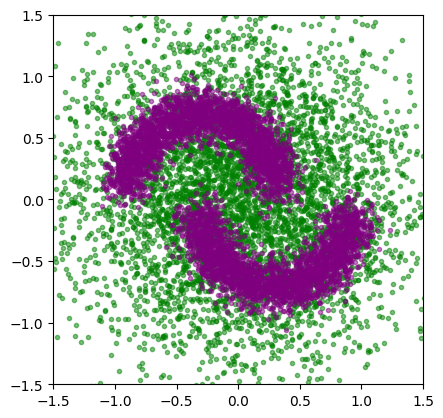

In [43]:
N = 5000
t = T

key, _ = jax.random.split(key)
x0 = get_samples(key, N)
key, _ = jax.random.split(key)
xi = jax.random.normal(key, (N, space_dim))
xt = x0 * jnp.exp(-alpha*t) + (1 - jnp.exp(-beta*t))*xi

xs = jnp.linspace(-2, 2, num = 20)
ys = jnp.linspace(-1, 1, num = 20)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

plt.scatter(xt[:,0], xt[:,1], color = "green", alpha = 0.5, marker = ".")
plt.scatter(x0[:,0], x0[:,1], color = "purple", alpha = 0.5, marker = ".")

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect(1.)

In [44]:
act = lambda x: nn.softplus(x)

class ScoreModel(nn.Module):
  @nn.compact
  def __call__(self, x, t):

    # space embedding
    a = nn.Dense(24)(x)
    a = act(a)
    a = nn.Dense(48)(a)
    a = act(a)

    # time embedding
    b = nn.Dense(24)(t)
    b = act(b)
    b = nn.Dense(48)(b)
    b = act(b)

    # full
    c = a + b

    # predict
    c = nn.Dense(64)(c)
    c = act(c)
    output = nn.Dense(2)(c)

    return output

In [45]:
model = ScoreModel()
param = model.init(key, jnp.empty((space_dim,)), jnp.empty((1,)))

In [46]:
@jax.jit
def calc_loss(param, samples, t, w):
    eval = model.apply(param, samples, t)
    a = jnp.sum(eval ** 2, axis = -1)
    c = 2*jnp.sum(w*jax.jvp(model.apply, (param, samples, t), (util.t_zeros_like(param), w, jnp.zeros_like(t)))[1], axis = -1)

    return jnp.mean(a + c)

@jax.jit
def grad_loss(param, samples, t, w):
    l = lambda param: calc_loss(param, samples, t, w)
    grad = jax.vjp(l, param)[1](jnp.array(1.))
    return grad[0]

In [47]:
losses = []
param = model.init(key, jnp.empty((space_dim,)), jnp.empty((1,)))
optimiser = optax.adam(1e-2)
opt_state = optimiser.init(param)
N = 3000

In [50]:
for i in tqdm(range(1000)):
    key, _ = jax.random.split(key)
    x0 = get_samples(key, N)
    key, _ = jax.random.split(key)
    xi = jax.random.normal(key, (N, space_dim))
    key, _ = jax.random.split(key)
    t = jax.random.uniform(key, (N, 1)) * 2 * T - T   # symmetric time ?
    xt = x0 * jnp.exp(-alpha*t) + (1 - jnp.exp(-beta*t))*xi
    key, _ = jax.random.split(key)
    w = jax.random.normal(key, (N, space_dim))

    loss = calc_loss(param, xt, t, w)
    losses.append(loss)
    grad = grad_loss(param, xt, t, w)

    updates, opt_state = optimiser.update(grad, opt_state)
    param = optax.apply_updates(param, updates)

100%|██████████| 1000/1000 [00:31<00:00, 31.72it/s]


(1, 100.0)

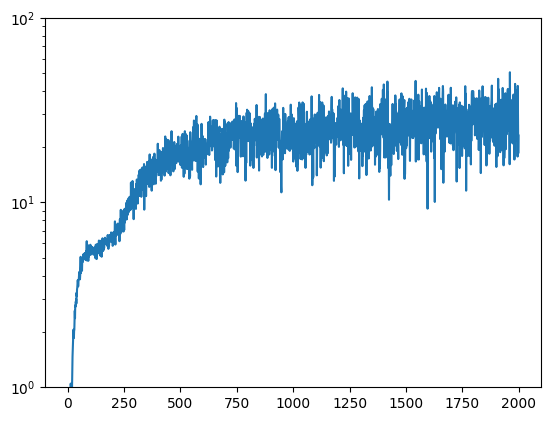

In [51]:
plt.plot(-jnp.array(losses))
plt.yscale("log")
plt.ylim(1, 1e2)

In [57]:
N = 3000

x = jax.random.normal(key, (N, space_dim))
t = 0
epsilon = 1e-2

while t + epsilon < T:
    key, _ = jax.random.split(key)

    t_eval = T - t
    sig = (1 - jnp.exp(-beta * t_eval)) * jnp.sqrt(2*alpha + (2*beta*jnp.exp(-beta * t_eval))/(1 - jnp.exp(-beta*t_eval)))
    dx = (alpha * x + sig ** 2 * model.apply(param, x, jnp.ones((N, 1))*t_eval))*epsilon + sig * jnp.sqrt(epsilon) * jax.random.normal(key, (N, space_dim))
    x = x + dx
    t = t + epsilon

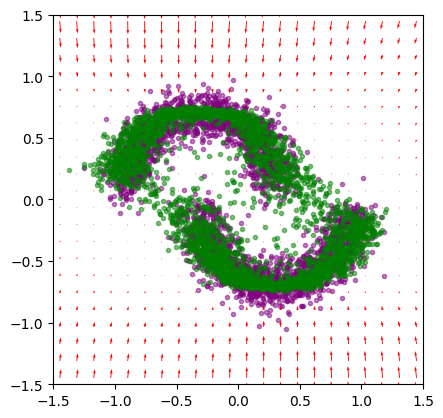

In [58]:
key, _ = jax.random.split(key)
x0 = get_samples(key, N)

xs = jnp.linspace(-2, 2, num = 30)
ys = jnp.linspace(-2, 2, num = 30)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

score_approx = model.apply(param, coord, jnp.ones((30, 30, 1)) * (T - t))

plt.scatter(x0[:,0], x0[:,1], color = "purple", alpha = 0.5, marker = ".")
plt.scatter(x[:,0], x[:,1], color = "green", alpha = 0.5, marker = ".")
plt.quiver(xx, yy, score_approx[...,0], score_approx[...,1], color = "r")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect(1.)